# Portfolio Analysis with Python Notebook 1

### 1.From Prices to Returns

Recall that the return from time $t$ to time ${t+1}$ is given by:

$$ R_{t,t+1} = \frac{P_{t+1}-P_{t}}{P_{t}} $$

or alternately

$$ R_{t,t+1} = \frac{P_{t+1}}{P_{t}} - 1 $$

In [1]:
import pandas as pd
prices = pd.DataFrame({"BLUE": [8.70, 8.91, 8.71, 8.43, 8.73],
                       "ORANGE": [10.66, 11.08, 10.71, 11.59, 12.11]})
# Method 1
ret_1 = prices.iloc[1:].values/prices.iloc[:-1] - 1

# Method 2
ret_2 = prices / prices.shift(1) - 1

# Method 3
ret_3 = prices.pct_change()

In [2]:
ret_1

,BLUE,ORANGE
0,0.024138,0.039400
1,-0.022447,-0.033394
2,-0.032147,0.082166
3,0.035587,0.044866


### 2. Compounding Returns

We have a series of 12 monthly returns, we can produce the compounded return by multiplying the individual period returns, as long as the returns are expressed as growth rates in what I call "1+R" format.

To compound the returns, all we need to do is add 1 to each return and then multiply them. The result is itself in "1+R" format, so we need to subtract 1.

In [3]:
(1+ret_1).prod()

BLUE      1.003448
ORANGE    1.136023
dtype: float64

In [4]:
def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())

### 3. Annualizing Returns

To annualize a return for a period, you compound the return for as many times as there are periods in a year. For instance, to annualize a monthly return you compund that return 12 times. The formula to annualize a monthly return $R_m$ is:

$$ (1+R_m)^{12} - 1$$

To annualize a quarterly return $R_q$ you would get:

$$ (1+R_q)^{4} - 1$$

And finally, to annualize a daily return $R_d$ you would get:

$$ (1+R_d)^{252} - 1$$

For example, to annualize a 1% monthly, and 4% quarterly and a 0.01% daily return you would do:

In [5]:
# 1% monthly
(1+0.01)**12 - 1

0.12682503013196977

In [6]:
# 4% quarterly
(1+0.04)**4 - 1

0.1698585600000002

In [7]:
# 0.01% daily return
(1+0.0001)**252 - 1

0.025518911987694626

In [8]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

### 3. Volatility and Risk

In [9]:
import numpy as np
prices = pd.read_csv("data/sample_prices.csv")
returns = prices.pct_change()
returns = returns.dropna()

In [10]:
deviations = returns - returns.mean()
squared_deviations = deviations**2
number_of_obs = returns.shape[0]
mean_squared_deviations = squared_deviations.sum()/(number_of_obs-1)
volatility = np.sqrt(mean_squared_deviations)
volatility

BLUE      0.023977
ORANGE    0.079601
dtype: float64

In [11]:
returns.std()

BLUE      0.023977
ORANGE    0.079601
dtype: float64

### 4. Annualizing Volatility

We annualize volatility by scaling (multiplying) it by the square root of the number of periods per observation

Therefore, to annualize the volatility of a monthly series, we muiltiply it by the square root of 12. Instead of using the np.sqrt() we can raise it to the power of  0.5

In [12]:
annualized_vol = (returns.std())*(12**0.5)
annualized_vol 

BLUE      0.083060
ORANGE    0.275747
dtype: float64

In [13]:
def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    """
    return r.std()*(periods_per_year**0.5)

### 5. Risk Adjusted Returns --- Sharpe Ratio

Let's get beyond the sample data series and start working with some real data. Read in the monthly returns of a set of 10 portfolios formed on market caps, or market equities of the companies. Of the 10 portfolios, we only want to look at the largest cap and the smallest cap companies:

In [14]:
me_m = pd.read_csv("data/Portfolios_Formed_on_ME_monthly_EW.csv",
                   header=0, index_col=0, parse_dates=True, na_values=-99.99)
me_m.head()

,<= 0,Lo 30,Med 40,Hi 30,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
192607,NaN,-0.43,1.52,2.68,-0.57,0.59,1.60,1.47,3.33,-1.45,0.29,-0.15,1.33,1.24,1.98,1.55,1.38,3.38,3.29
192608,NaN,3.90,3.04,2.09,3.84,3.59,3.71,1.61,2.33,5.12,2.59,4.03,3.15,2.72,4.72,1.60,1.63,0.98,3.70
192609,NaN,-1.08,-0.54,0.16,-0.48,-1.40,0.00,-0.50,-0.09,0.93,-1.87,-2.27,-0.53,0.07,-0.07,-1.64,0.64,-0.86,0.67
192610,NaN,-3.32,-3.52,-3.06,-3.29,-4.10,-2.89,-3.36,-2.95,-4.84,-1.77,-3.36,-4.83,-2.98,-2.80,-3.45,-3.27,-3.47,-2.43
192611,NaN,-0.46,3.82,3.09,-0.55,2.18,3.41,3.39,3.16,-0.78,-0.32,-0.29,4.65,3.24,3.57,3.82,2.95,3.61,2.70


In [15]:
cols = ['Lo 10', 'Hi 10']
returns = me_m[cols]

Note that the data is already given in percentages (i.e 4.5 instead of 0.045) and we typically want to use the actual numbers (i.e. 0.045 instead of 4.5) so we should divide the raw data from the file by 100.

In [16]:
returns = returns / 100
returns.columns = ['SmallCap','LargeCap']
returns.plot(figsize=(12,4))

In [17]:
annualized_vol = annualize_vol(returns, 12)
annualized_vol

SmallCap    0.368193
LargeCap    0.186716
dtype: float64

In [18]:
annualized_rets = annualize_rets(returns, 12)
annualized_rets

SmallCap    0.167463
LargeCap    0.092810
dtype: float64

In [19]:
riskfree_rate = 0.03
excess_rets = annualized_rets - riskfree_rate
sharpe_ratio = excess_rets/annualized_vol
sharpe_ratio

SmallCap    0.373346
LargeCap    0.336392
dtype: float64

In [20]:
def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

### 6. Computing Maximum Drawdown
1. Convert the time series of returns to a time series that represents a wealth index
2. Compute a time series of the previous peaks
3. Compute the Drawdown as the difference between the previous peak and the current value

In [21]:
# forcing the index to be a datetime
returns.index = pd.to_datetime(returns.index, format="%Y%m").to_period('M')

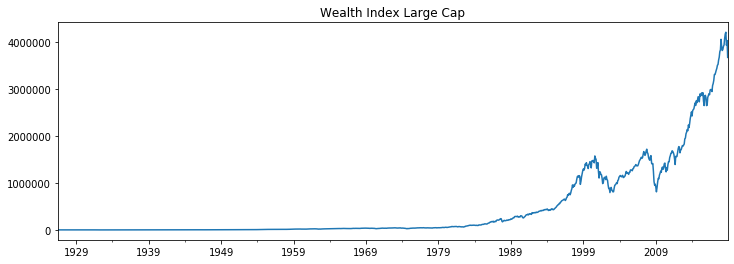

In [22]:
wealth_index = 1000*(1+returns["LargeCap"]).cumprod()
wealth_index.plot(figsize=(12,4), title="Wealth Index Large Cap")

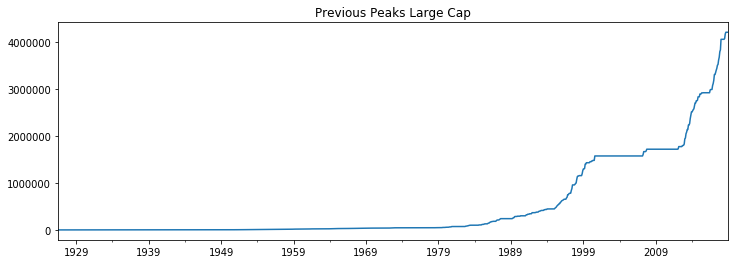

In [23]:
previous_peaks = wealth_index.cummax()
previous_peaks.plot(figsize=(12,4), title="Previous Peaks Large Cap")

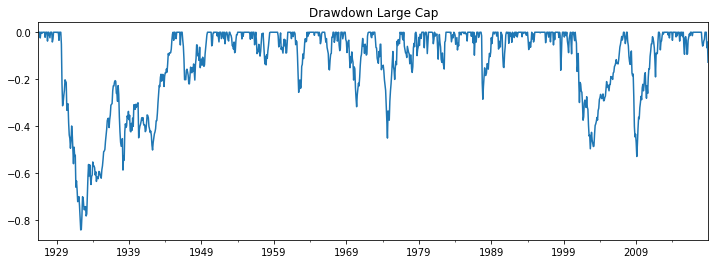

In [24]:
drawdown = (wealth_index - previous_peaks)/previous_peaks
drawdown.plot(figsize=(12,4), title="Drawdown Large Cap")

In [25]:
# Max Drawdown
-drawdown.min()

0.8400375277943123

In [26]:
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

### 7. Skewness
Intuitively, a negative skew means that you get more negative returns than you would have expected if the returns were distributed like the normal distribution.

Another way of thinking about it is if that returns are normally distributed, the mean and the median would be very close.

However, if they are negatively skewed, the expected value i.e. the mean is less than the median. If they are positively skewed, the expected value (again, the mean) is greater than the median.

$$ S(R) = \frac{E[ (R-E(R))^3 ]}{\sigma_R^3} $$

In [27]:
hfi = pd.read_csv("data/edhec-hedgefundindices.csv",
                      header=0, index_col=0, parse_dates=True)
hfi = hfi/100
hfi.index = hfi.index.to_period('M')

In [28]:
hfi.head()

,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
1997-01,0.0119,0.0393,0.0178,0.0791,0.0189,0.0213,0.0191,0.0573,0.0281,0.0150,0.0180,-0.0166,0.0317
1997-02,0.0123,0.0298,0.0122,0.0525,0.0101,0.0084,0.0122,0.0175,-0.0006,0.0034,0.0118,0.0426,0.0106
1997-03,0.0078,-0.0021,-0.0012,-0.0120,0.0016,-0.0023,0.0109,-0.0119,-0.0084,0.0060,0.0010,0.0778,-0.0077
1997-04,0.0086,-0.0170,0.0030,0.0119,0.0119,-0.0005,0.0130,0.0172,0.0084,-0.0001,0.0122,-0.0129,0.0009
1997-05,0.0156,-0.0015,0.0233,0.0315,0.0189,0.0346,0.0118,0.0108,0.0394,0.0197,0.0173,-0.0737,0.0275


In [29]:
def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3

In [30]:
skewness(hfi).sort_values()

Fixed Income Arbitrage   -3.940320
Convertible Arbitrage    -2.639592
Equity Market Neutral    -2.124435
Relative Value           -1.815470
Event Driven             -1.409154
Merger Arbitrage         -1.320083
Distressed Securities    -1.300842
Emerging Markets         -1.167067
Long/Short Equity        -0.390227
Funds Of Funds           -0.361783
CTA Global                0.173699
Short Selling             0.767975
Global Macro              0.982922
dtype: float64

In [31]:
import scipy.stats
scipy.stats.skew(hfi)

array([-2.63959223,  0.17369864, -1.30084204, -1.16706749, -2.12443538,
       -1.40915356, -3.94032029,  0.98292188, -0.39022677, -1.32008333,
       -1.81546975,  0.76797484, -0.36178308])

### 8. Kurtosis

Intuitively, the kurtosis measures the "fatness" of the tails of the distribution. The normal distribution has a kurtosis of 3 and so if the kurtosis of your returns is less than 3 then it tends to have thinner tails, and if the kurtosis is greater than 3 then the distribution has fatter tails.

Kurtosis is given by:

$$ K(R) = \frac{E[ (R-E(R))^4 ]}{\sigma_R^4} $$

In [32]:
def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4

In [33]:
kurtosis(hfi).sort_values()

CTA Global                 2.952960
Long/Short Equity          4.523893
Global Macro               5.741679
Short Selling              6.117772
Funds Of Funds             7.070153
Distressed Securities      7.889983
Event Driven               8.035828
Merger Arbitrage           8.738950
Emerging Markets           9.250788
Relative Value            12.121208
Equity Market Neutral     17.218555
Convertible Arbitrage     23.280834
Fixed Income Arbitrage    29.842199
dtype: float64

In [34]:
scipy.stats.kurtosis(hfi)

array([20.28083446, -0.04703963,  4.88998336,  6.25078841, 14.21855526,
        5.03582817, 26.84219928,  2.74167945,  1.52389258,  5.73894979,
        9.12120787,  3.11777175,  4.07015278])

### 9. Jarque-Bera Test for Normality

In [35]:
scipy.stats.jarque_bera(hfi)

(25656.585999171326, 0.0)

The first number is the test statistic and the second number is the one we want. It represents the p-value for the hypothesis test. If you want to run the test at a 1% level of significance, you want this number to be greater than 0.01 to accept the hypothesis that the data is normally distributed, and if that number is less than 0.01 then you must reject the hypothesis of normality.

In [36]:
import scipy.stats
def is_normal(r, level=0.01):
    """
    Applies the Jarque-Bera test to determine if a Series is normal or not
    Test is applied at the 1% level by default
    Returns True if the hypothesis of normality is accepted, False otherwise
    """
    statistic, p_value = scipy.stats.jarque_bera(r)
    return p_value > level

In [37]:
# Use the .aggregate method on a dataframe, 
# that takes a function as an argument and applies that function to each column:
hfi.aggregate(is_normal)

Convertible Arbitrage     False
CTA Global                 True
Distressed Securities     False
Emerging Markets          False
Equity Market Neutral     False
Event Driven              False
Fixed Income Arbitrage    False
Global Macro              False
Long/Short Equity         False
Merger Arbitrage          False
Relative Value            False
Short Selling             False
Funds Of Funds            False
dtype: bool

### 10. SemiDeviation

In [38]:
def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    is_negative = r < 0
    return r[is_negative].std(ddof=0)

In [39]:
semideviation(hfi)

Convertible Arbitrage     0.019540
CTA Global                0.012443
Distressed Securities     0.015185
Emerging Markets          0.028039
Equity Market Neutral     0.009566
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Global Macro              0.006579
Long/Short Equity         0.014051
Merger Arbitrage          0.008875
Relative Value            0.012244
Short Selling             0.027283
Funds Of Funds            0.012122
dtype: float64

### 11. VaR and CVaR

We'll look at three different ways to compute Value At Risk

1. Historic VaR
2. Parametric Gaussian VaR
3. Modified (Cornish-Fisher) VaR

To compute the historic VaR at a certain level, say 5%, all we have to do is to find the number such that 5% of the returns fall below that number and 95% of the returns fall above that number. In other words, we want the 5 percentile return.

In [40]:
def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")   

In [41]:
var_historic(hfi, level=3)

Convertible Arbitrage     0.021750
CTA Global                0.035512
Distressed Securities     0.023314
Emerging Markets          0.050692
Equity Market Neutral     0.011242
Event Driven              0.028370
Fixed Income Arbitrage    0.010480
Global Macro              0.017628
Long/Short Equity         0.037696
Merger Arbitrage          0.013726
Relative Value            0.018514
Short Selling             0.084896
Funds Of Funds            0.026428
dtype: float64

### 12. Conditional VaR aka Beyond VaR

find the mean of the numbers that fell below the VaR

In [42]:
def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [43]:
cvar_historic(hfi, level=1).sort_values()

Global Macro              0.029333
Equity Market Neutral     0.036100
Merger Arbitrage          0.036233
Relative Value            0.052367
CTA Global                0.054767
Funds Of Funds            0.061133
Long/Short Equity         0.061867
Distressed Securities     0.070967
Event Driven              0.071267
Fixed Income Arbitrage    0.072467
Convertible Arbitrage     0.086100
Short Selling             0.123867
Emerging Markets          0.141167
dtype: float64

### 13. Parametric Gaussian VaR
If a set of returns is normally distributed, In general we can always convert a percentile point to a z-score (which is the number of standard deviations away from the mean that a number is). Therefore, if we can convert the VaR level (such as 1% or 5%) to a z-score, we can calculate the return level where that percent of returns lie below it.

scipy.stat.norm contains a function ppf() which does exactly that. It takes a percentile such as 0.05 or 0.01 and gives you the z-score corresponding to that in the normal distribution.

In [44]:
from scipy.stats import norm
norm.ppf(.5)

0.0

Therefore, all we need to do to estimate the VaR using this method is to find the z-score corresponding to percentile level, and then add that many standard deviations to the mean, to obtain the VaR.

In [45]:
def var_gaussian(r, level=5):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    return -(r.mean() + z*r.std(ddof=0))

In [46]:
var_gaussian(hfi, level=1)

Convertible Arbitrage     0.032960
CTA Global                0.050107
Distressed Securities     0.032623
Emerging Markets          0.069296
Equity Market Neutral     0.014380
Event Driven              0.032533
Fixed Income Arbitrage    0.022428
Global Macro              0.028780
Long/Short Equity         0.039956
Merger Arbitrage          0.016978
Relative Value            0.020873
Short Selling             0.112563
Funds Of Funds            0.031880
dtype: float64

### 14. Cornish-Fisher Modification
The basic idea is that since we can observe the skewness and kurtosis of the data, we can adjust the z-score up or down to come up with a modifed z-score. e.g. intuitively, all other things being equal, if the skewness is negative, we'll decrease the z-score further down, and if the skewness is positive, we'll push it up.

The adjusted z-score which we'll call $z_{cornishfisher}$ given by:

$$ z_{cornishfisher} = z +\frac{1}{6}(z^2-1)S + \frac{1}{24}(z^3-3z)(K-3)-\frac{1}{36}(2z^3-5z)S^2 $$

In [47]:
from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )

    return -(r.mean() + z*r.std(ddof=0))

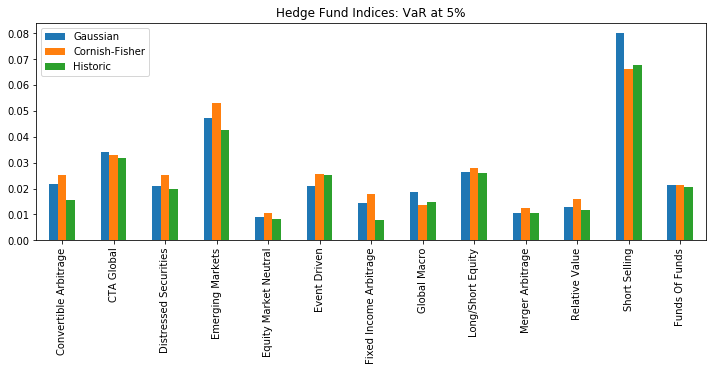

In [49]:
var_table = [var_gaussian(hfi), 
             var_gaussian(hfi, modified=True), 
             var_historic(hfi)]
comparison = pd.concat(var_table, axis=1)
comparison.columns=['Gaussian', 'Cornish-Fisher', 'Historic']
comparison.plot.bar(title="Hedge Fund Indices: VaR at 5%", figsize=(12,4))

### 15. Efficient Frontier --- The 2-Asset Case

we are going to learn how to compute the efficient frontier when we have a set of expected returns, volatilities (or variances) and correlations (or covariances). It's a fair question as to how we can get these numbers for the future, but for now, we'll assume that historic returns are a reasonable estimate. In future sections, we'll learn how to improve on it.

Let's start by importing a new dataset. This is the Ken French dataset of the returns of 30 different industry portfolios.

In [50]:
ind = pd.read_csv("data/ind30_m_vw_rets.csv", header=0, index_col=0)/100
ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')

In [51]:
ind.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


In [52]:
ind.columns

Index(['Food ', 'Beer ', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth ',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal ', 'Oil  ', 'Util ', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin  ', 'Other'],
      dtype='object')

Note that the column names have embedded spaces. We can strip out the leading and trailing spaces in the Series by using the .str.strip method.

In [53]:
ind.columns = ind.columns.str.strip()

For now, let's assume that we can estiamte these simply by looking back in time and naively assuming they will hold in the future. 

In [58]:
# Compute expected return and covariance
er = annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

In [59]:
def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

In [60]:
l = ["Food", "Beer", "Smoke", "Coal"]
er[l]

Food     0.116799
Beer     0.141126
Smoke    0.107830
Coal     0.414689
dtype: float64

In [61]:
cov.loc[l,l]

,Food,Beer,Smoke,Coal
Food,0.002609,0.002379,0.002061,0.000027
Beer,0.002379,0.005264,0.001359,0.001728
Smoke,0.002061,0.001359,0.008349,-0.000733
Coal,0.000027,0.001728,-0.000733,0.018641


In [63]:
ew = np.repeat(0.25, 4)
portfolio_return(ew, er[l])

0.19511097196038385

In [64]:
portfolio_vol(ew, cov.loc[l,l])

0.055059195776437045

In [65]:
def plot_ef2(n_points, er, cov):
    """
    Plots the 2-asset efficient frontier
    """
    if er.shape[0] != 2:
        raise ValueError("plot_ef2 can only plot 2-asset frontiers")
    weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style=".-")

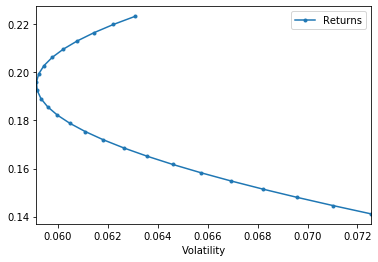

In [66]:
l = ["Fin", "Beer"]
plot_ef2(25, er[l].values, cov.loc[l,l])

### 16. Efficient Frontier --- Running the Optimizer
In order to plot the frontier for portfolios with more than 2 assets, we need to find the weights of the portfolio on the efficient frontier.

The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal because they do not provide enough return for the level of risk. 

In order to find the optimal weights, we need a function that will minimize the volatility for a given level of return.

In [71]:
from scipy.optimize import minimize

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x

In [72]:
weights_15 = minimize_vol(0.15, er[l], cov.loc[l,l])
weights_15

array([0.10789883, 0.89210117])

In [73]:
vol_15 = portfolio_vol(weights_15, cov.loc[l,l])
vol_15

0.06878027296869563

Now that we can find the weights to minimize the vol given a target return, we can plot the efficient frontier by dividing up the range from the highest to the lowest possible return into a grid, and finding the portfolio that targets the minimum volatility given a particular targeted rate of return.

In [75]:
def optimal_weights(n_points, er, cov):
    """
    return weights with min vol given a list 
    of target return
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov) # not yet implemented!
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')

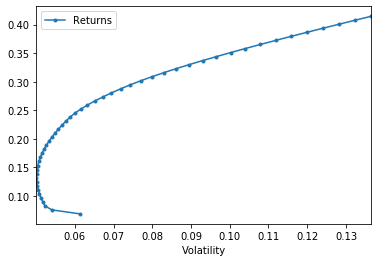

In [77]:
l = ["Smoke", "Fin", "Games", "Coal"]
plot_ef(50, er[l], cov.loc[l,l])

### 17. Max Sharpe Ratio Portfolio
We've already seen that given a set of expected returns and a covariance matrix, we can plot the efficient frontier. In this section, we'll extend the code to locate the point on the efficient frontier that we are most interested in, which is the tangency portfolio or the Max Sharpe Ratio portfolio.

We already know how to identify points on the curve if we are given a target rate of return. Instead of minimizing the vol based on a target return, we want to find that one point on the curve that maximizes the Sharpe Ratio, given the risk free rate.

In [78]:
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n) # Initial guess: all assets have the same weights
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol

    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

In [80]:
rf = 0.1
w_msr = msr(rf, er, cov)

In [81]:
w_msr

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.48932500e-15,
       0.00000000e+00, 0.00000000e+00, 5.45480127e-15, 4.55961462e-01,
       8.10280096e-16, 2.15496315e-15, 2.67314408e-15, 1.97311109e-15,
       1.52936446e-15, 2.33810838e-01, 2.14489135e-15, 0.00000000e+00,
       9.01619313e-15, 1.38704167e-01, 0.00000000e+00, 8.94091715e-02,
       0.00000000e+00, 2.13532897e-15, 1.55177068e-02, 6.11494428e-16,
       2.46290006e-15, 0.00000000e+00, 6.65966553e-02, 1.35272882e-15,
       0.00000000e+00, 1.93143388e-15])

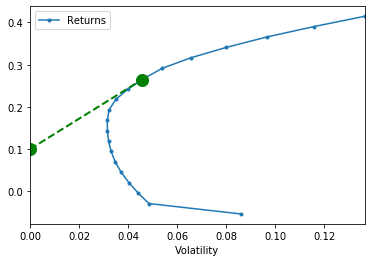

In [82]:
# plot EF
ax = plot_ef(20, er, cov)
ax.set_xlim(left = 0)
# get MSR
rf = 0.1
w_msr = msr(rf, er, cov)
r_msr = portfolio_return(w_msr, er)
vol_msr = portfolio_vol(w_msr, cov)
# add CML
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

Update plot_ef, adding the CML.

In [85]:
def plot_ef(n_points, er, cov, style='-', show_cml=False, riskfree_rate=0.1):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov) # not yet implemented!
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    ax = ef.plot.line(x="Volatility", y="Returns", style=style)
    
    if show_cml:
        ax.set_xlim(left = 0)
        # get MSR
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
        
    return ax

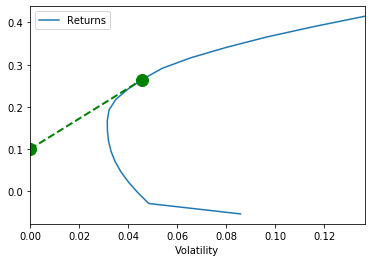

In [86]:
plot_ef(20, er, cov, style='-', show_cml=True, riskfree_rate=0.1)

### 18. Lack of Robustness of the Markowitz procedure
We see that even a small change in the estimate causes a major change in the weights. 

One way to avoid this estimation game is to skip the entire process and just rely on naive diversification, which means hold all stocks with equal weight. We can add the EW portfolio to the plot by enhancing the plot_ef function

In [87]:
def plot_ef(n_points, er, cov, style='-', show_cml=False, show_ew=False, riskfree_rate=0.1):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov) # not yet implemented!
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    ax = ef.plot.line(x="Volatility", y="Returns", style=style)
    
    if show_cml:
        ax.set_xlim(left = 0)
        # get MSR
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
        
    if show_ew:
        n = er.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = portfolio_return(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        ax.plot([vol_ew], [r_ew], color='goldenrod', marker='o', markersize=10)
        
    return ax

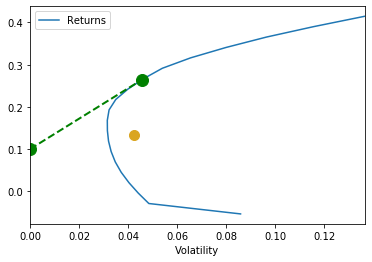

In [88]:
plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1, show_ew=True)

### 19. Global Minimum Volatility (GMV) portfolio
If you assume that all returns are the same, the optimizer cannot improve the sharpe ratio through raising returns, and so it must do so my lowering volatility. This means that if we just skip any returns estimation and assume all returns have the return, we'd get the weights of the GMV portfolio

In [89]:
def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

def plot_ef(n_points, er, cov, style='-', show_cml=False, show_ew=False, show_gmv=False, riskfree_rate=0.1):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov) # not yet implemented!
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    ax = ef.plot.line(x="Volatility", y="Returns", style=style)
    
    if show_cml:
        ax.set_xlim(left = 0)
        # get MSR
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
        
    if show_ew:
        n = er.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = portfolio_return(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        ax.plot([vol_ew], [r_ew], color='goldenrod', marker='o', markersize=10)
        
    if show_gmv:
        w_gmv = gmv(cov)
        r_gmv = portfolio_return(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        ax.plot([vol_gmv], [r_gmv], color='midnightblue', marker='o', markersize=10)
        
    return ax

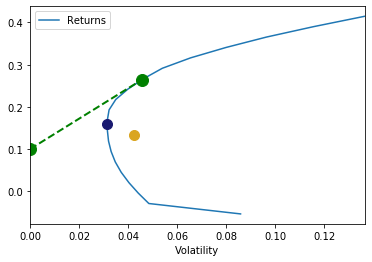

In [91]:
plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1, show_ew=True, show_gmv=True)

### 20. Implementing a Cap-Weighted Portfolio

In [92]:
# Load and format the Ken French 30 Industry Portfolios Average number of Firms
ind_nfirms = pd.read_csv("data/ind30_m_nfirms.csv", header=0, index_col=0)
ind_nfirms.index = pd.to_datetime(ind_nfirms.index, format="%Y%m").to_period('M')
ind_nfirms.columns = ind_nfirms.columns.str.strip()

# Load and format the Ken French 30 Industry Portfolios Average size (market cap)
ind_size = pd.read_csv("data/ind30_m_size.csv", header=0, index_col=0)
ind_size.index = pd.to_datetime(ind_size.index, format="%Y%m").to_period('M')
ind_size.columns = ind_size.columns.str.strip()

In [93]:
ind_nfirms.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-08,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-09,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-10,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-11,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4


In [94]:
ind_size.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,35.98,7.12,59.72,26.41,12.02,22.27,18.36,25.52,57.59,6.18,...,350.36,13.60,56.70,35.35,66.91,1.19,46.65,10.82,18.83,24.25
1926-08,36.10,6.75,60.47,27.17,13.33,22.13,19.83,25.80,62.13,6.20,...,353.27,14.75,57.74,37.86,67.99,0.90,46.57,11.00,18.88,25.51
1926-09,37.00,8.58,64.03,27.30,14.67,21.18,19.29,26.73,65.53,6.71,...,360.96,15.05,59.61,36.82,71.02,0.95,46.11,10.94,19.67,27.21
1926-10,37.14,8.92,64.42,28.76,14.42,21.23,19.03,26.87,68.47,6.82,...,364.16,15.30,59.52,34.77,70.83,0.88,46.15,10.80,19.36,26.16
1926-11,35.88,8.62,65.08,27.38,15.79,20.14,19.03,26.54,65.06,6.84,...,363.74,14.89,58.74,32.80,68.75,0.74,45.03,10.33,18.35,23.94


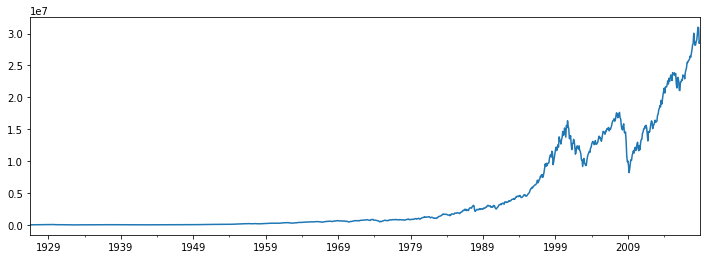

In [96]:
ind_mktcap = ind_nfirms * ind_size
total_mktcap = ind_mktcap.sum(axis=1)
total_mktcap.plot.line(figsize=(12,4))

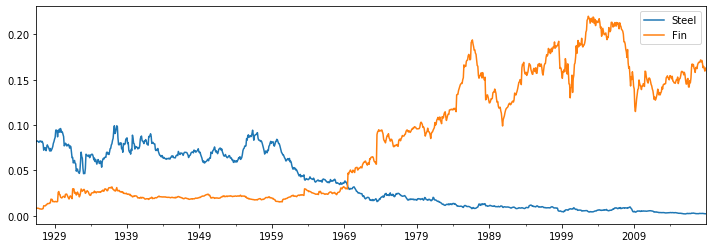

In [97]:
ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
ind_capweight[['Steel','Fin']].plot.line(figsize=(12,4))

In [99]:
ind.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


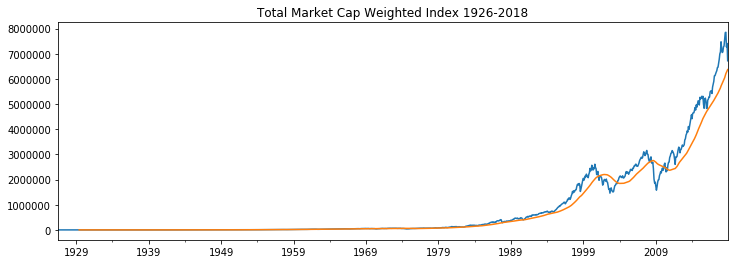

In [103]:
# Cap Weighted Market Index
ind_return = ind
total_market_return = (ind_capweight * ind_return).sum(axis="columns")
total_market_index = drawdown(total_market_return).Wealth
total_market_index.plot(title="Total Market Cap Weighted Index 1926-2018", figsize=(12,4))
total_market_index.rolling(window=36).mean().plot()

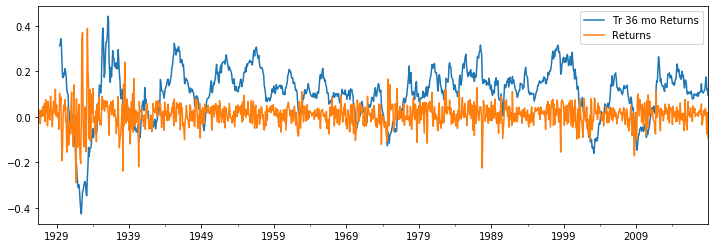

In [106]:
# annualized returns over the trailing 36 months and the average correlation across stocks over that same 36 months.
tmi_tr36rets = total_market_return.rolling(window=36).aggregate(annualize_rets, periods_per_year=12)
tmi_tr36rets.plot(figsize=(12,4), label="Tr 36 mo Returns", legend=True)
total_market_return.plot(label="Returns", legend=True)

### 21.Implementing Portfolio Insurance (CPPI) and Drawdown Constraints

1.Compute the cushion (asset value minus floor)
2.Compute the allocation (based on the multiplier)
3.Compute the new asset value

In [108]:
tmi_return = total_market_return 

In [109]:
risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]
# Assume the safe asset is paying 3% per year
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r.values[:] = 0.03/12 # fast way to set all values to a number
start = 1000 # start at $1000
floor = 0.80 # set the floor to 80 percent of the starting value

In [119]:
def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03):
    """
    Run a backtest of the CPPI strategy, given a set of returns for the risky asset
    Returns a dictionary containing: Asset Value History, Risk Budget History, Risky Weight History
    """
    # set up the CPPI parameters
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor

    if isinstance(risky_r, pd.Series): 
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/12 # fast way to set all values to a number
    # set up some DataFrames for saving intermediate values
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)

    for step in range(n_steps):
        cushion = (account_value - floor_value)/account_value
        risky_w = m*cushion
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)
        safe_w = 1-risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        # recompute the new account value at the end of this step
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
        # save the histories for analysis and plotting
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value
    risky_wealth = start*(1+risky_r).cumprod()
    backtest_result = {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth, 
        "Risk Budget": cushion_history,
        "Risky Allocation": risky_w_history,
        "m": m,
        "start": start,
        "floor": floor,
        "risky_r":risky_r,
        "safe_r": safe_r
    }
    return backtest_result


def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

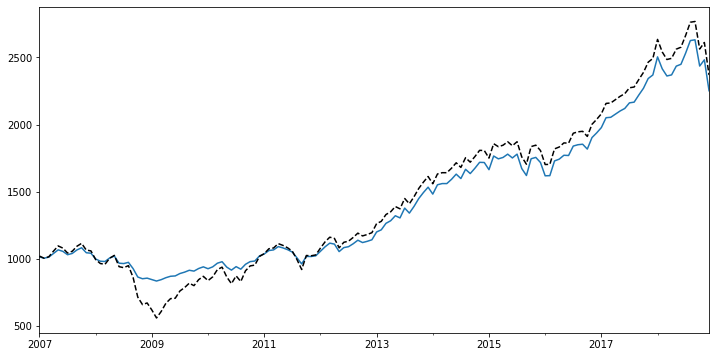

In [115]:
btr = run_cppi(tmi_return["2007":])
ax = btr["Wealth"].plot(legend=False, figsize=(10, 5))
btr["Risky Wealth"].plot(ax = ax, style="k--", legend=False, figsize=(12,6))

In [120]:
btr = run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]])
summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.014490,0.126906,-1.554266,11.668243,0.068652,0.098467,-0.341351,-0.404132
Fin,0.054690,0.109579,-0.254976,5.589082,0.047503,0.068951,0.219159,-0.216868
Beer,0.101518,0.114363,-0.743585,4.527865,0.051074,0.069081,0.608531,-0.217280


In [121]:
summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


### 22. Explicitly Limiting Drawdowns

In [122]:
def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03, drawdown=None):
    """
    Run a backtest of the CPPI strategy, given a set of returns for the risky asset
    Returns a dictionary containing: Asset Value History, Risk Budget History, Risky Weight History
    """
    # set up the CPPI parameters
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor
    peak = account_value

    if isinstance(risky_r, pd.Series): 
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/12 # fast way to set all values to a number
    # set up some DataFrames for saving intermediate values
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)

    for step in range(n_steps):
        if drawdown is not None:
            peak = np.maximum(peak, account_value)
            floor_value = peak*(1-drawdown)  
        cushion = (account_value - floor_value)/account_value
        risky_w = m*cushion
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)
        safe_w = 1-risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        # recompute the new account value at the end of this step
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
        # save the histories for analysis and plotting
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value
    risky_wealth = start*(1+risky_r).cumprod()
    backtest_result = {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth, 
        "Risk Budget": cushion_history,
        "Risky Allocation": risky_w_history,
        "m": m,
        "start": start,
        "floor": floor,
        "risky_r":risky_r,
        "safe_r": safe_r
    }
    return backtest_result

In [124]:
btr = run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]], drawdown=0.25)
summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.051189,0.613413,-0.161186
